# KMeans

Based on <https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html>

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data
from common.paths import HEALTHY, ADHD

X, Y, demographics, population = get_data(label_path=ADHD)
ages = demographics['Age']
sexes = demographics['Sex']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (380, 34716) | Y: 6 | Age: (380,) | Population: adhd


In [3]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

## Determine number of clusters

### Silhouette Analysis

In [6]:
%%time

range_n_clusters = [n for n in range(2, 6)]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f'Num clusters: {n_clusters} | Avg silhouette score: {silhouette_avg}')

Num clusters: 2 | Avg silhouette score: 0.12292705476284027
Num clusters: 3 | Avg silhouette score: 0.12636087834835052
Num clusters: 4 | Avg silhouette score: 0.06492592394351959
Num clusters: 5 | Avg silhouette score: 0.04043480381369591


### Bayesian Information Criterion

In [4]:
%%time

range_n_clusters = [n for n in range(2, 6)]
bics = []
X_ss = StandardScaler().fit_transform(X)

for n_clusters in range_n_clusters:
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag', reg_covar=1e-5)
    gmm.fit(X_ss)
    bic = gmm.bic(X_ss)
    bics.append(bic)
    print(f'Num clusters: {n_clusters} | BIC: {bic}')

Num clusters: 2 | BIC: 36072779.25020869
Num clusters: 3 | BIC: 36033548.757943995
Num clusters: 4 | BIC: 34991761.77942424
Num clusters: 5 | BIC: 35126754.2402493
CPU times: user 57 s, sys: 3.64 s, total: 1min
Wall time: 6.31 s


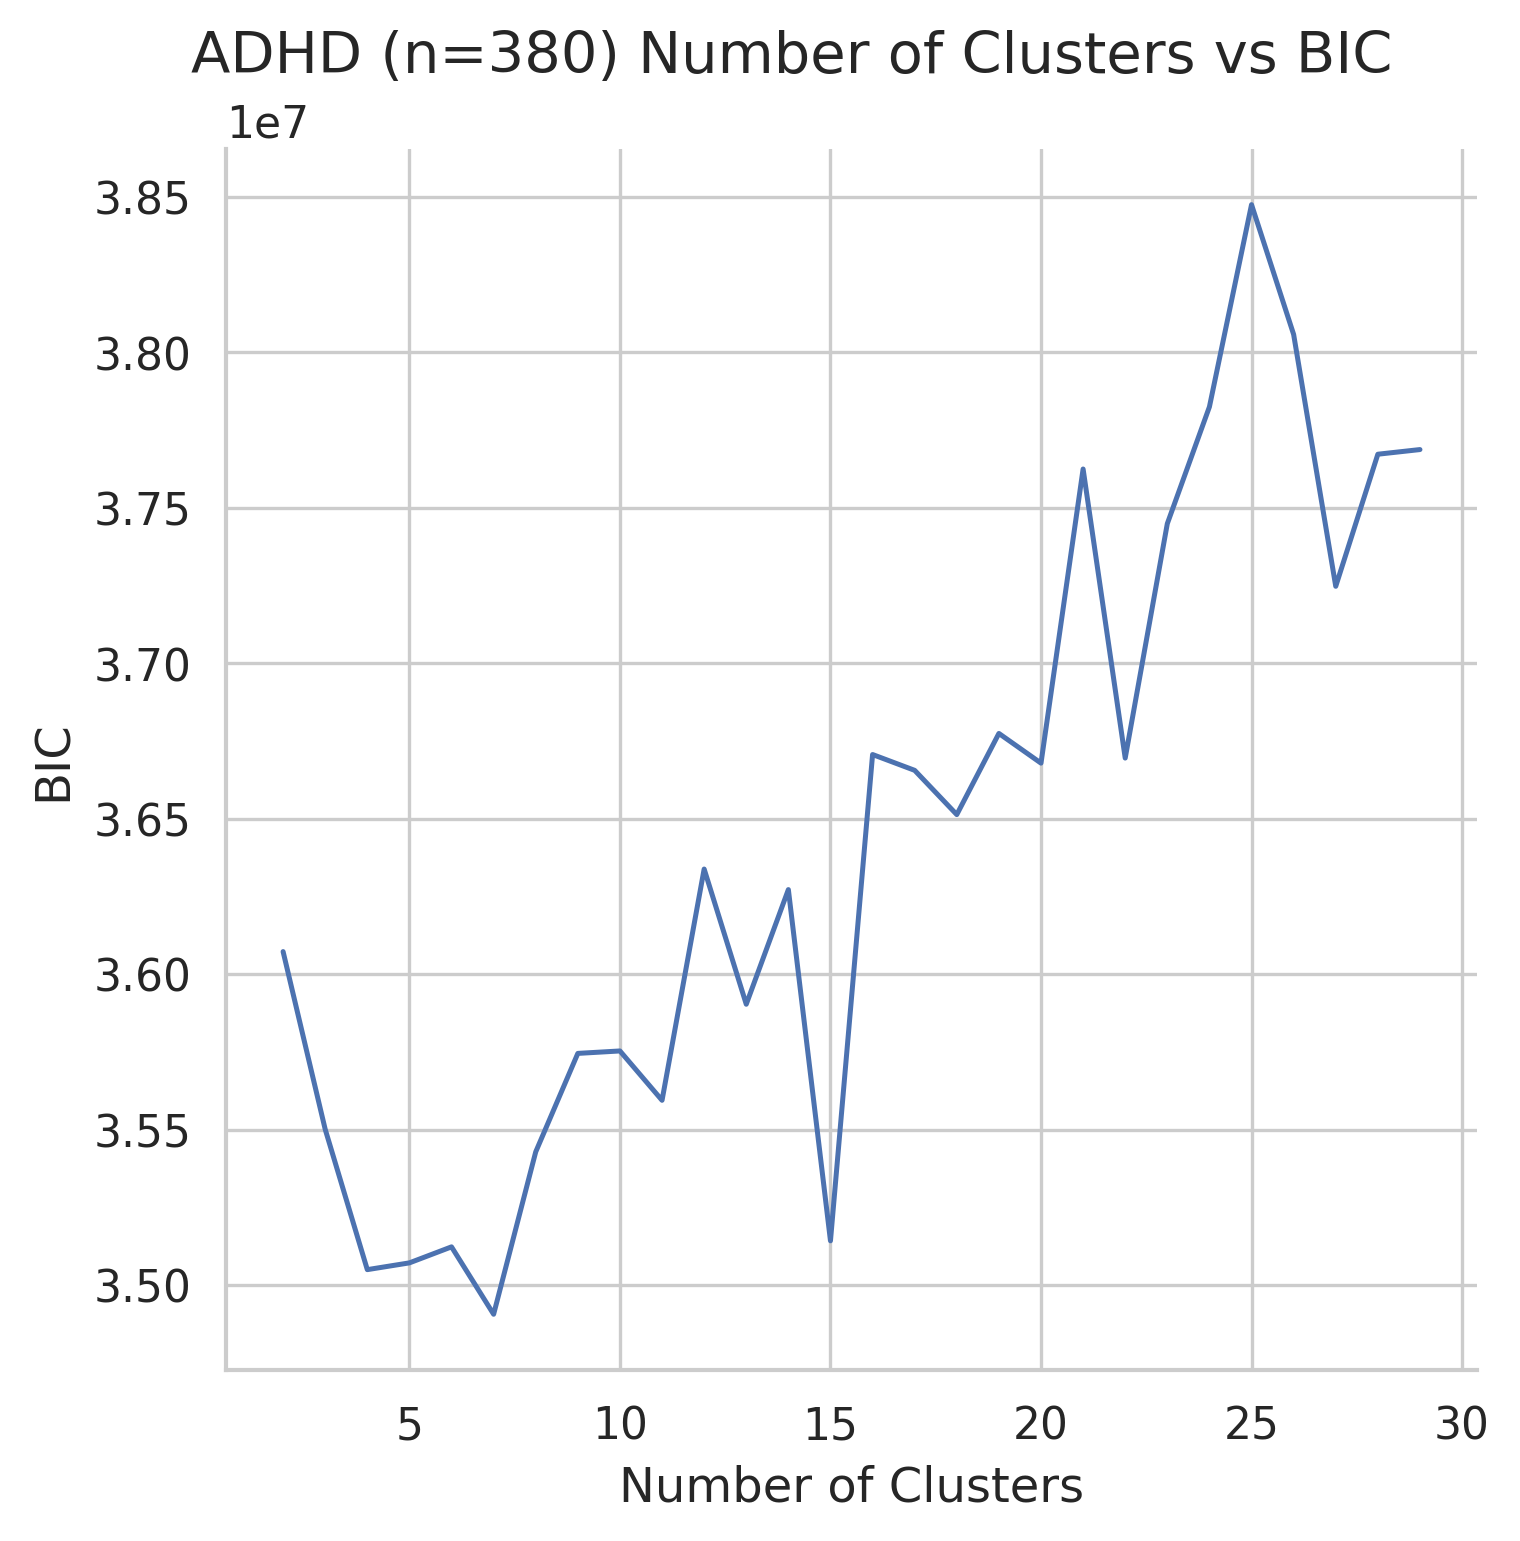

In [25]:
g = sns.relplot(x=range_n_clusters, y=bics, kind="line")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('ADHD (n=380) Number of Clusters vs BIC')
g.set_axis_labels('Number of Clusters', 'BIC')

## Run Clustering

In [9]:
clusters = 6
clusterer = KMeans(n_clusters=clusters)
cluster_labels = clusterer.fit_predict(X)

cluster_indices = []
for cluster in range(0, clusters):
    cluster_indices.append(np.where(cluster_labels == cluster))

In [10]:
ages_clusters = [ages[indices] for indices in cluster_indices]
sexes_clusters = [sexes[indices] for indices in cluster_indices]

for cluster, age_cluster in enumerate(ages_clusters):
    print(f"Cluster {cluster} Age: {np.mean(age_cluster):.2f} ({np.std(age_cluster):.2f})")

print("---")
    
for cluster, sex_cluster in enumerate(sexes_clusters):
    label, counts = np.unique(sex_cluster, return_counts=True)
    print(f"Cluster {cluster} Sex: {label, counts}")
#     print(f"Cluster {cluster} Sex: M={counts[0]} F={counts[1]}")

Cluster 0 Age: 9.65 (2.19)
Cluster 1 Age: 10.73 (2.25)
Cluster 2 Age: 9.90 (2.43)
Cluster 3 Age: 11.23 (2.40)
Cluster 4 Age: 11.06 (2.75)
Cluster 5 Age: 9.55 (0.00)
---
Cluster 0 Sex: (array([0, 1]), array([57, 14]))
Cluster 1 Sex: (array([0, 1]), array([29, 11]))
Cluster 2 Sex: (array([0, 1]), array([48, 26]))
Cluster 3 Sex: (array([0, 1]), array([78, 35]))
Cluster 4 Sex: (array([0, 1]), array([66, 15]))
Cluster 5 Sex: (array([0]), array([1]))


No handles with labels found to put in legend.


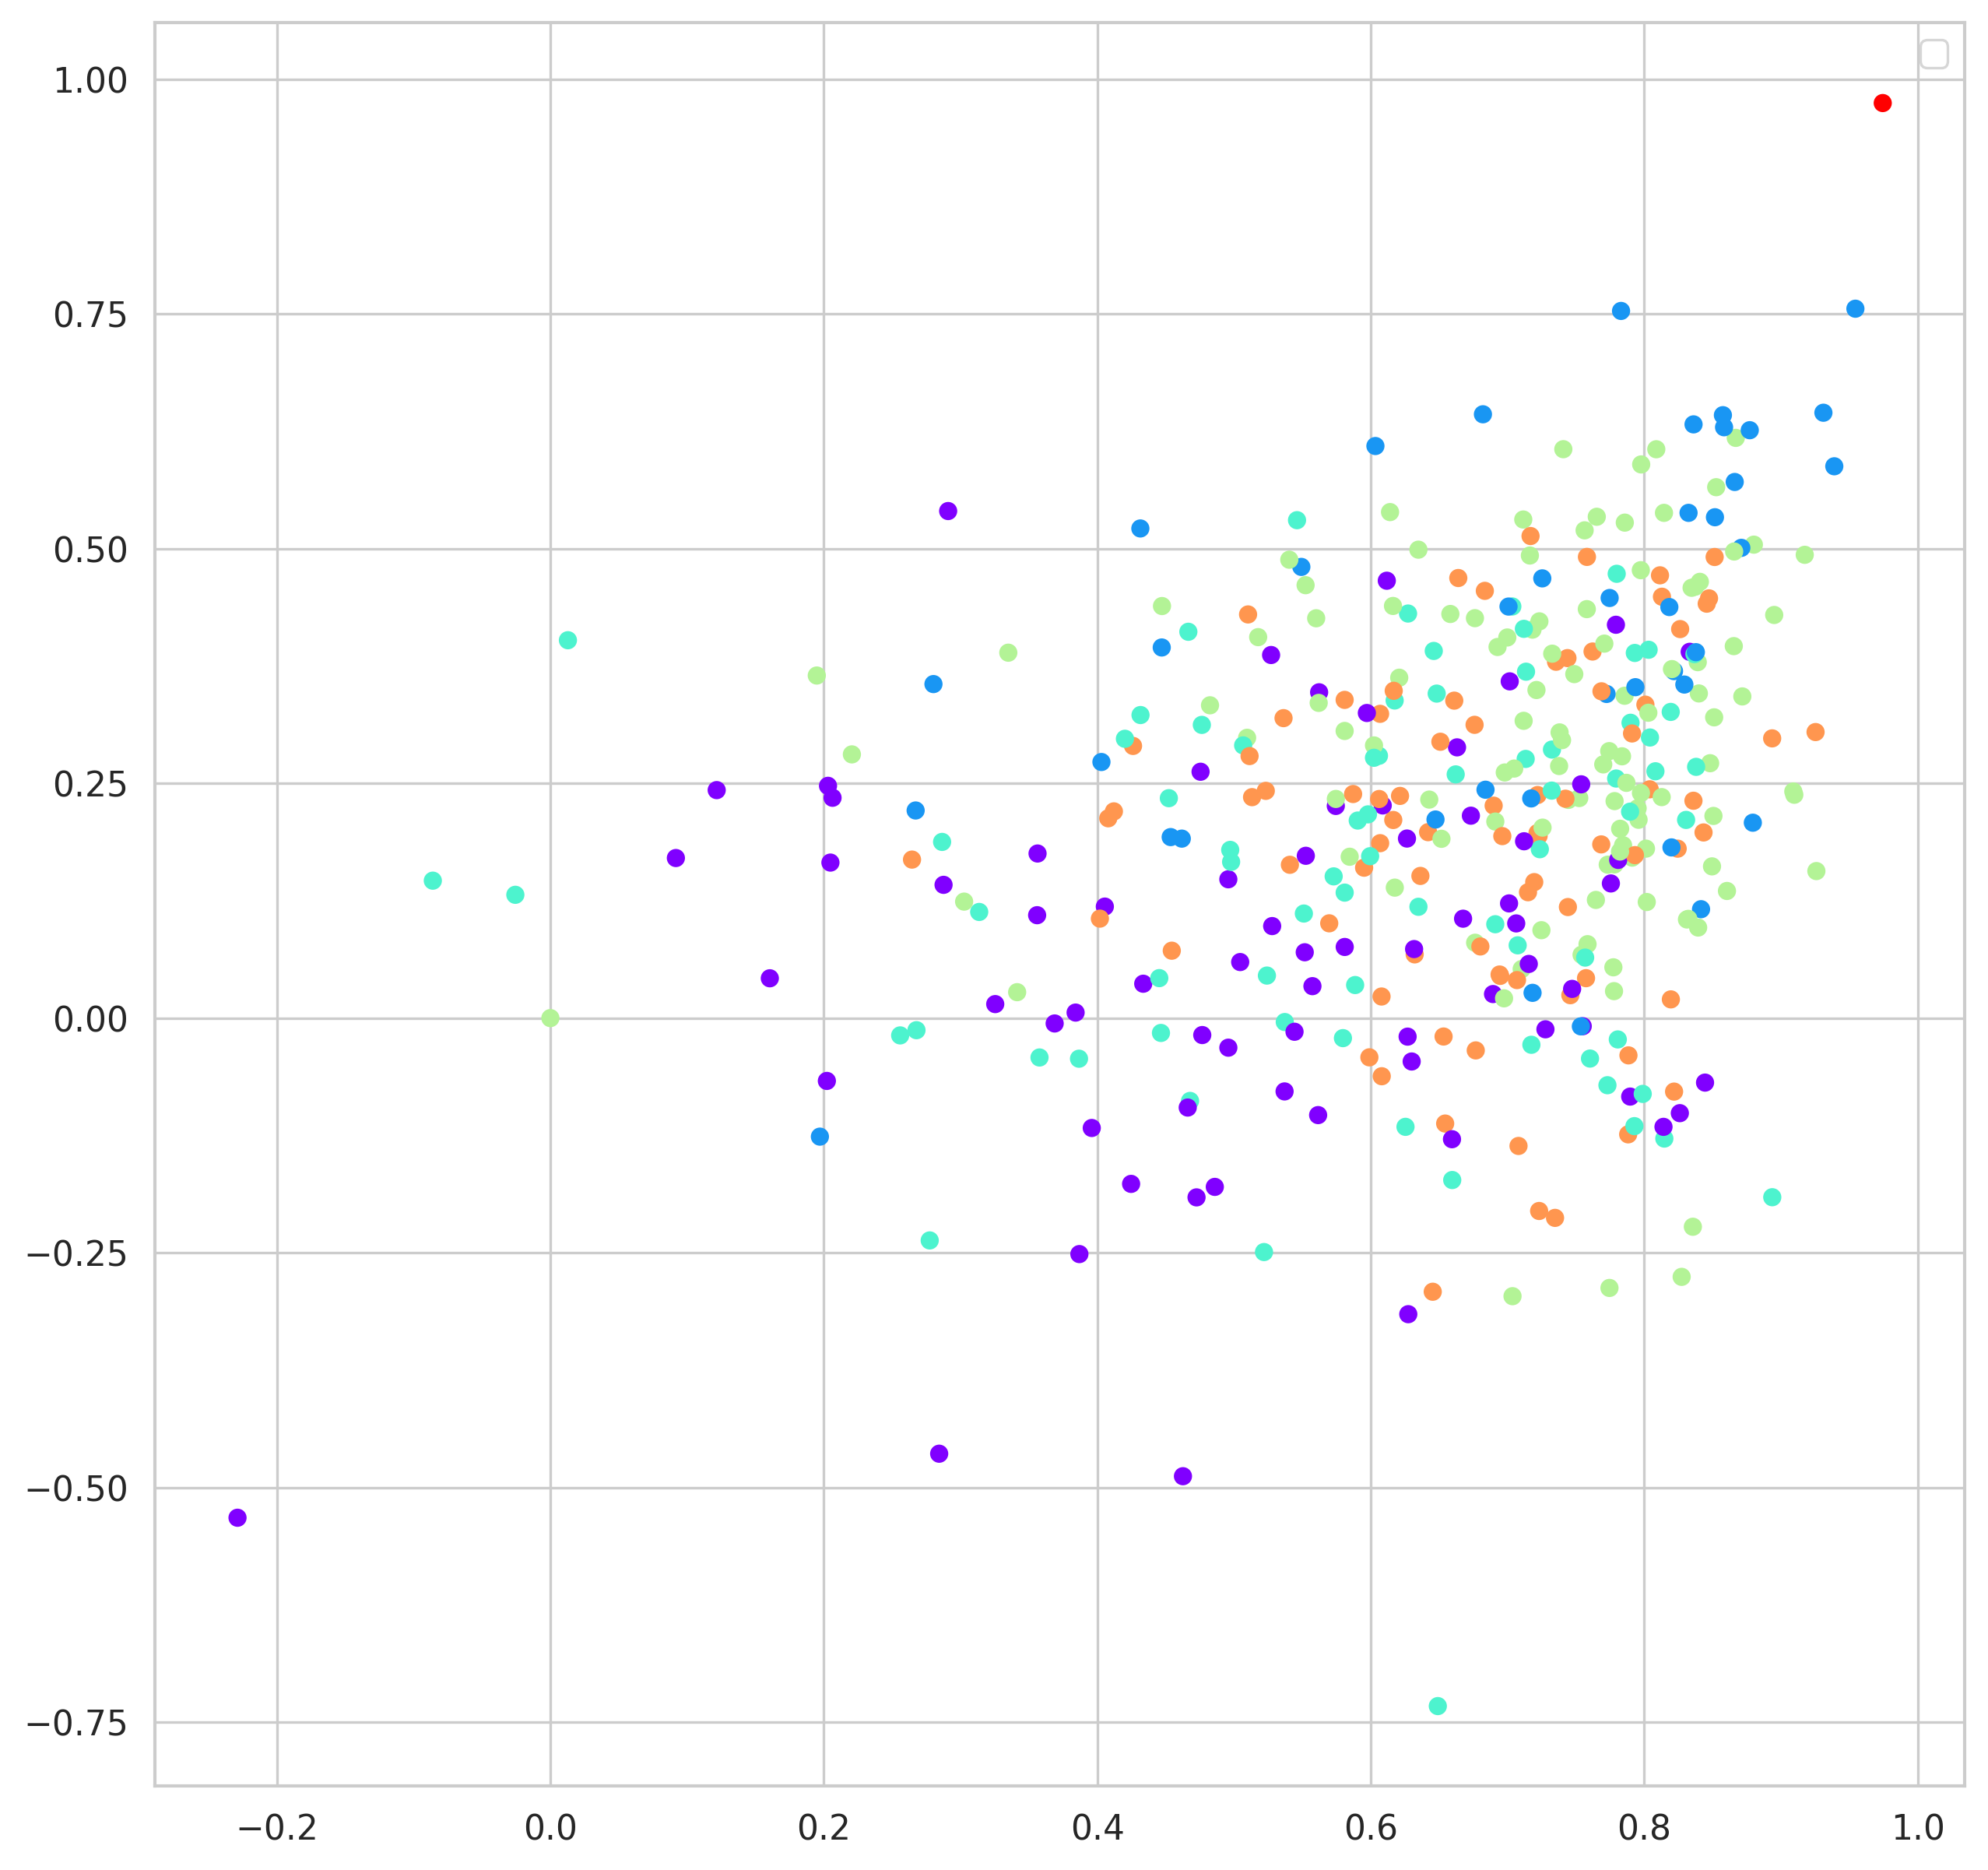

In [20]:
plt.scatter(X[:,0],X[:,1], c=clusterer.labels_, cmap='rainbow')

In [23]:
X[cluster_indices[-1]]

array([[ 0.97443247,  0.97443247, -0.97443247, ...,  0.97443247,
        -0.97443247, -0.97443247]], dtype=float32)

(array([297]),) (array([  4,  15,  18,  21,  22,  25,  37,  39,  42,  54,  72,  73,  90,
        94, 104, 109, 111, 112, 116, 123, 124, 132, 134, 140, 141, 142,
       146, 151, 159, 171, 183, 185, 196, 206, 207, 208, 209, 213, 214,
       220, 223, 225, 226, 232, 235, 238, 253, 257, 261, 262, 272, 276,
       278, 279, 282, 291, 296, 300, 301, 307, 308, 311, 322, 324, 329,
       345, 351, 354, 357, 360, 372]),)


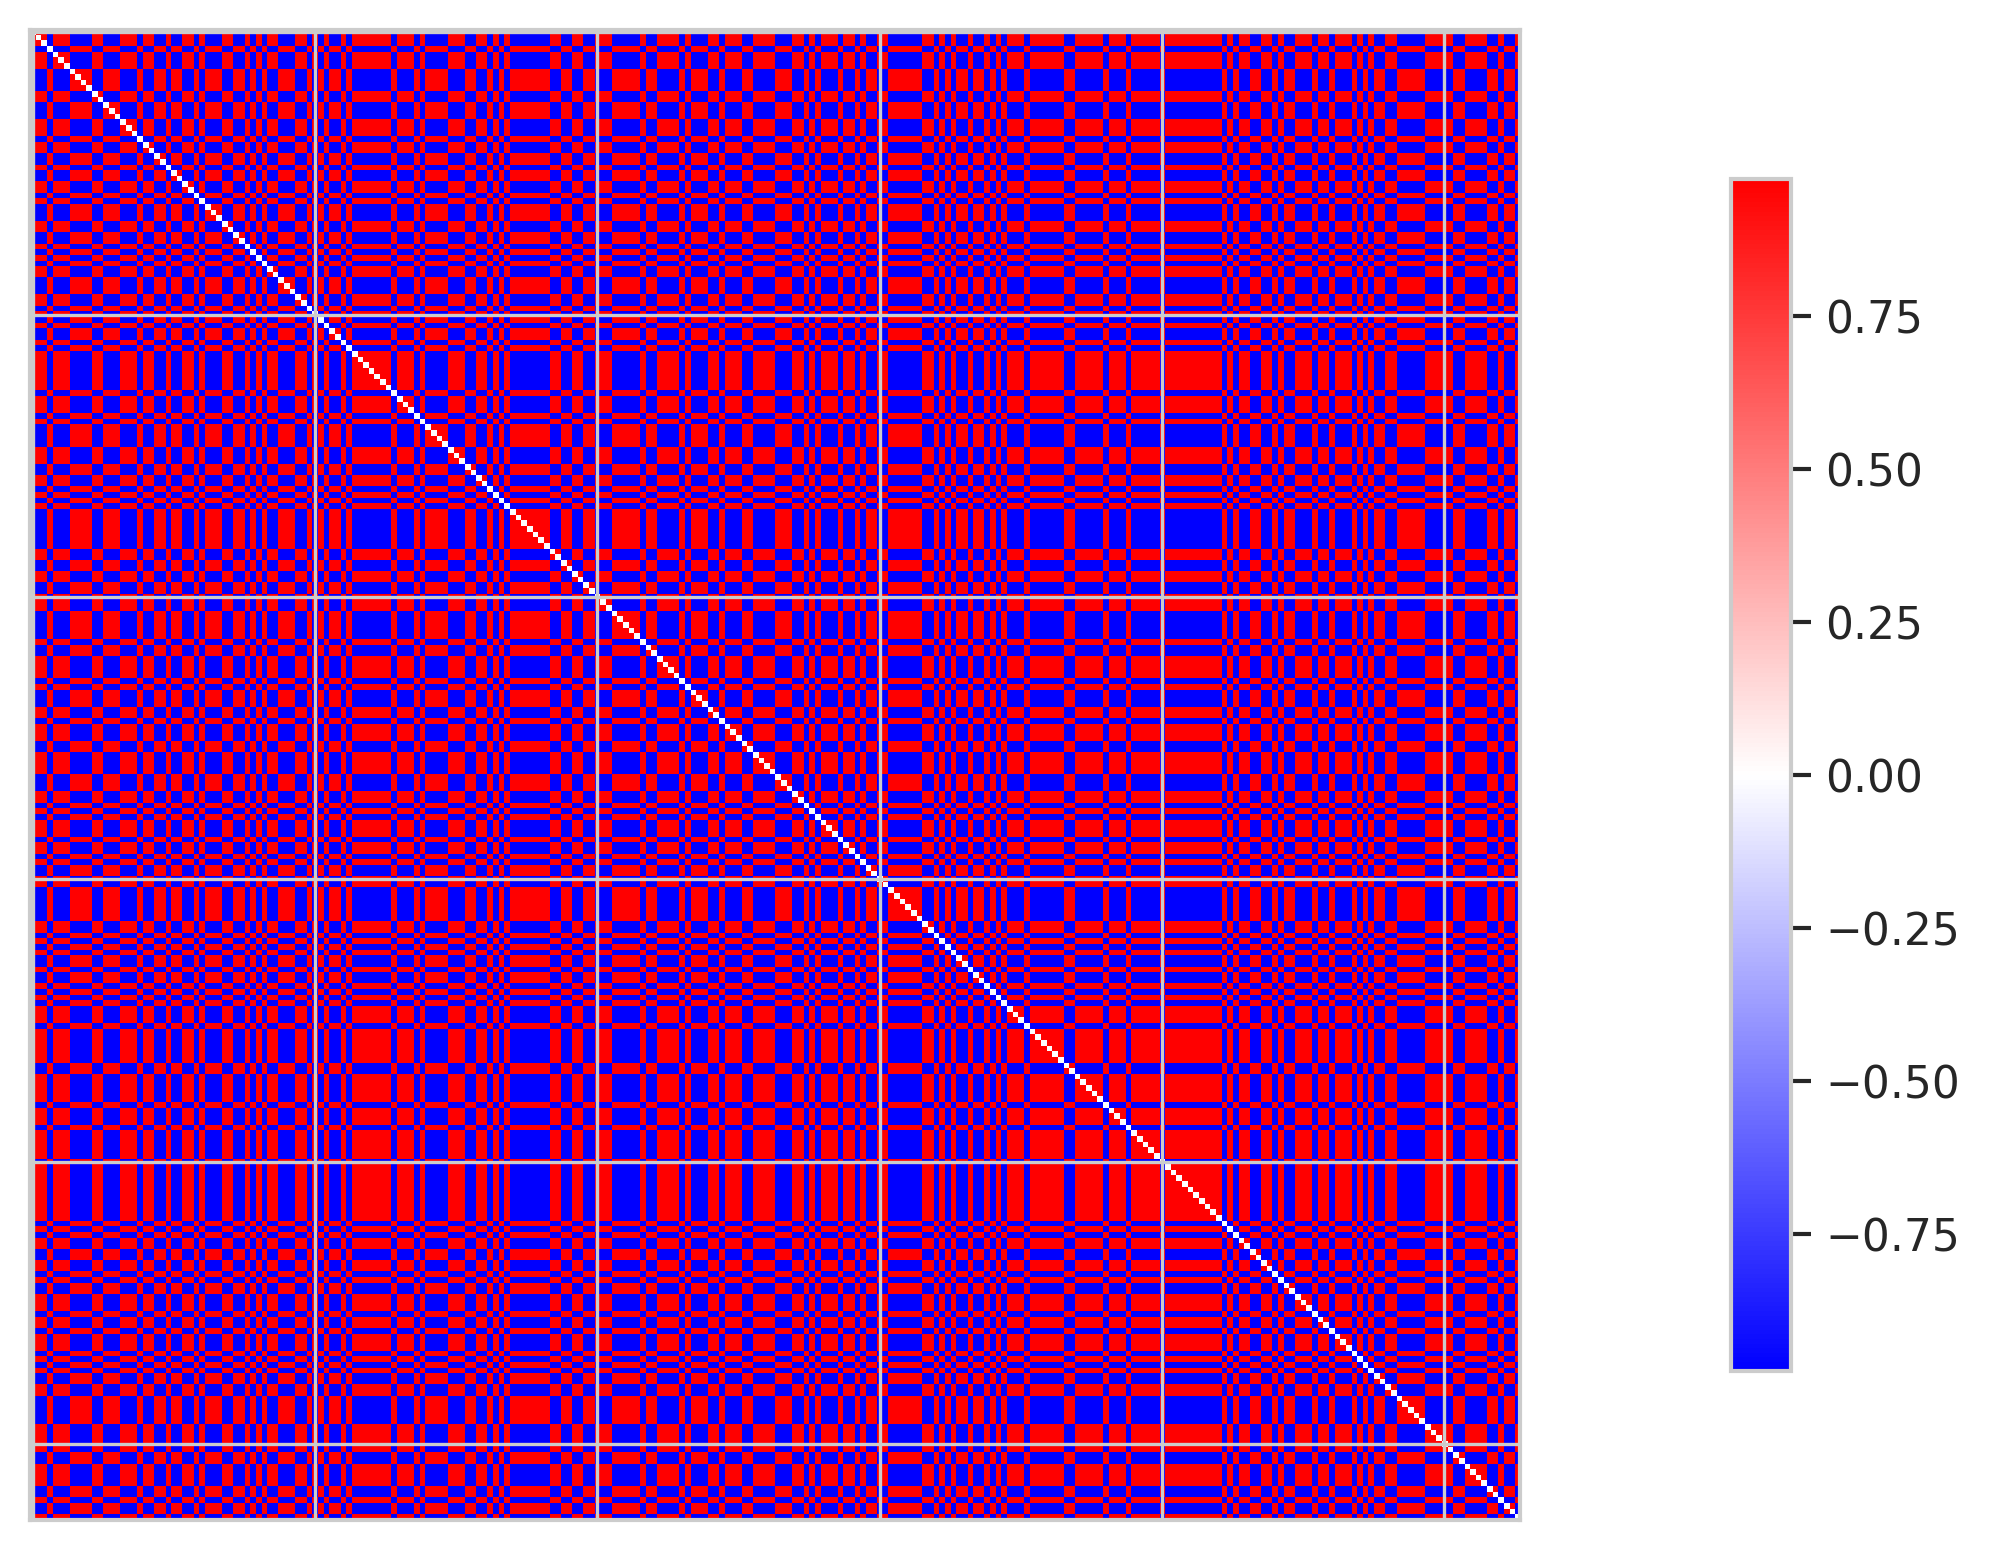

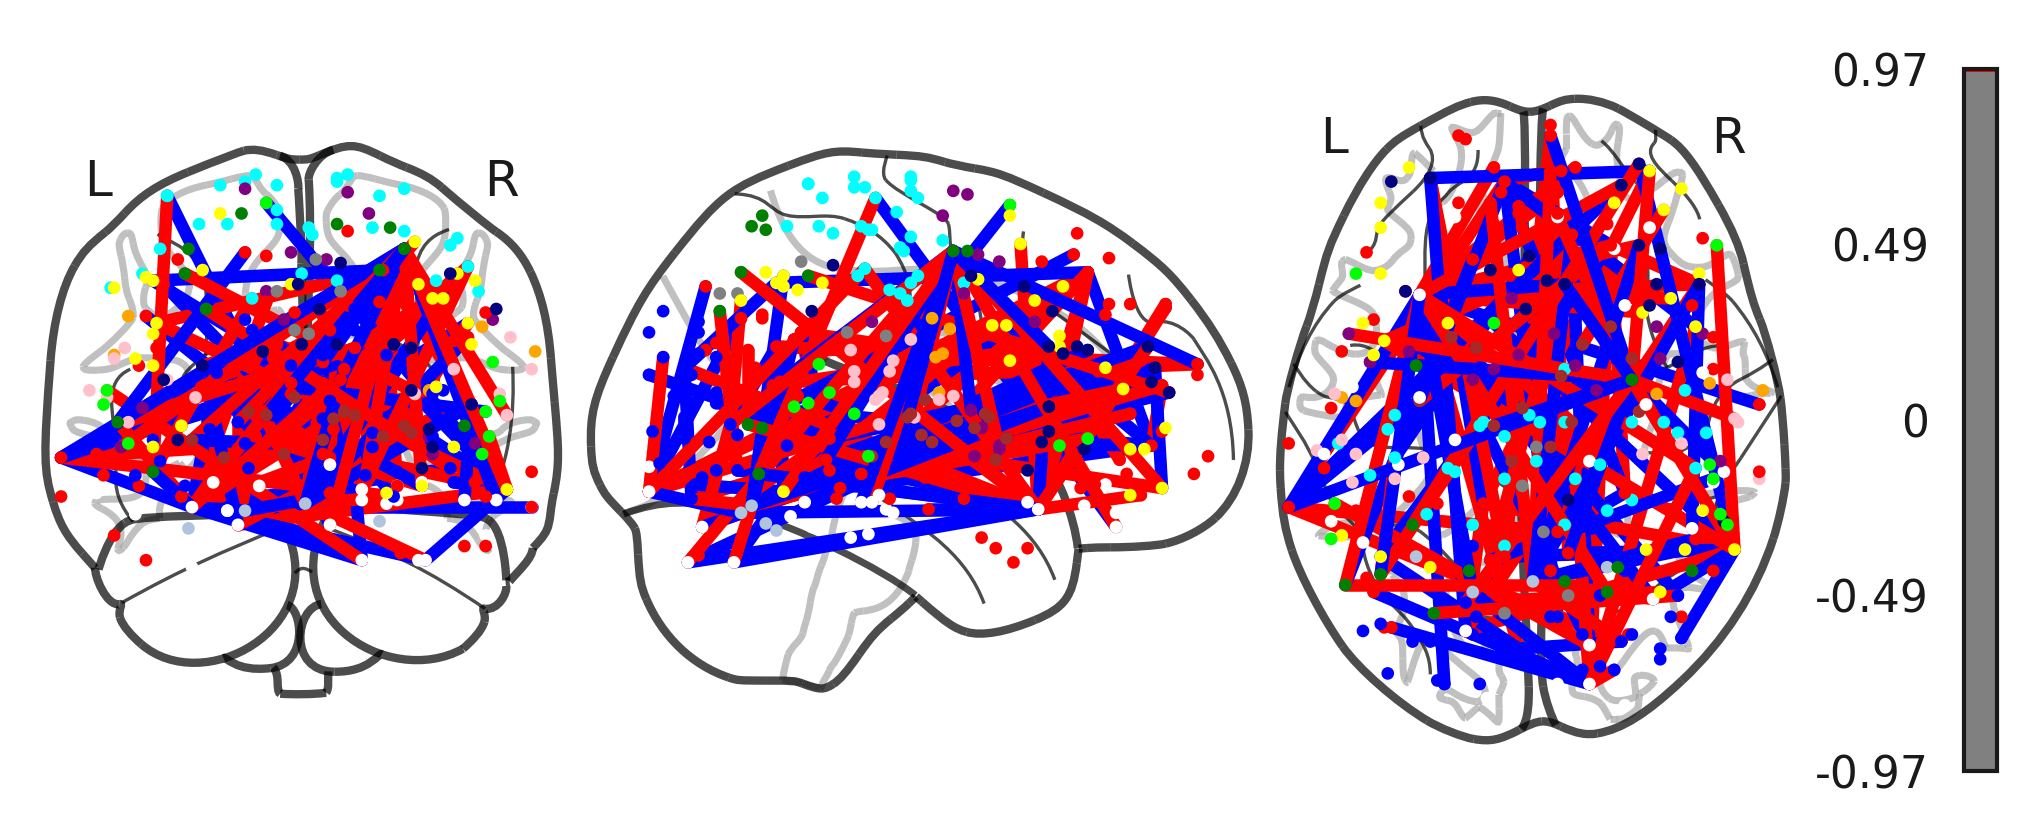

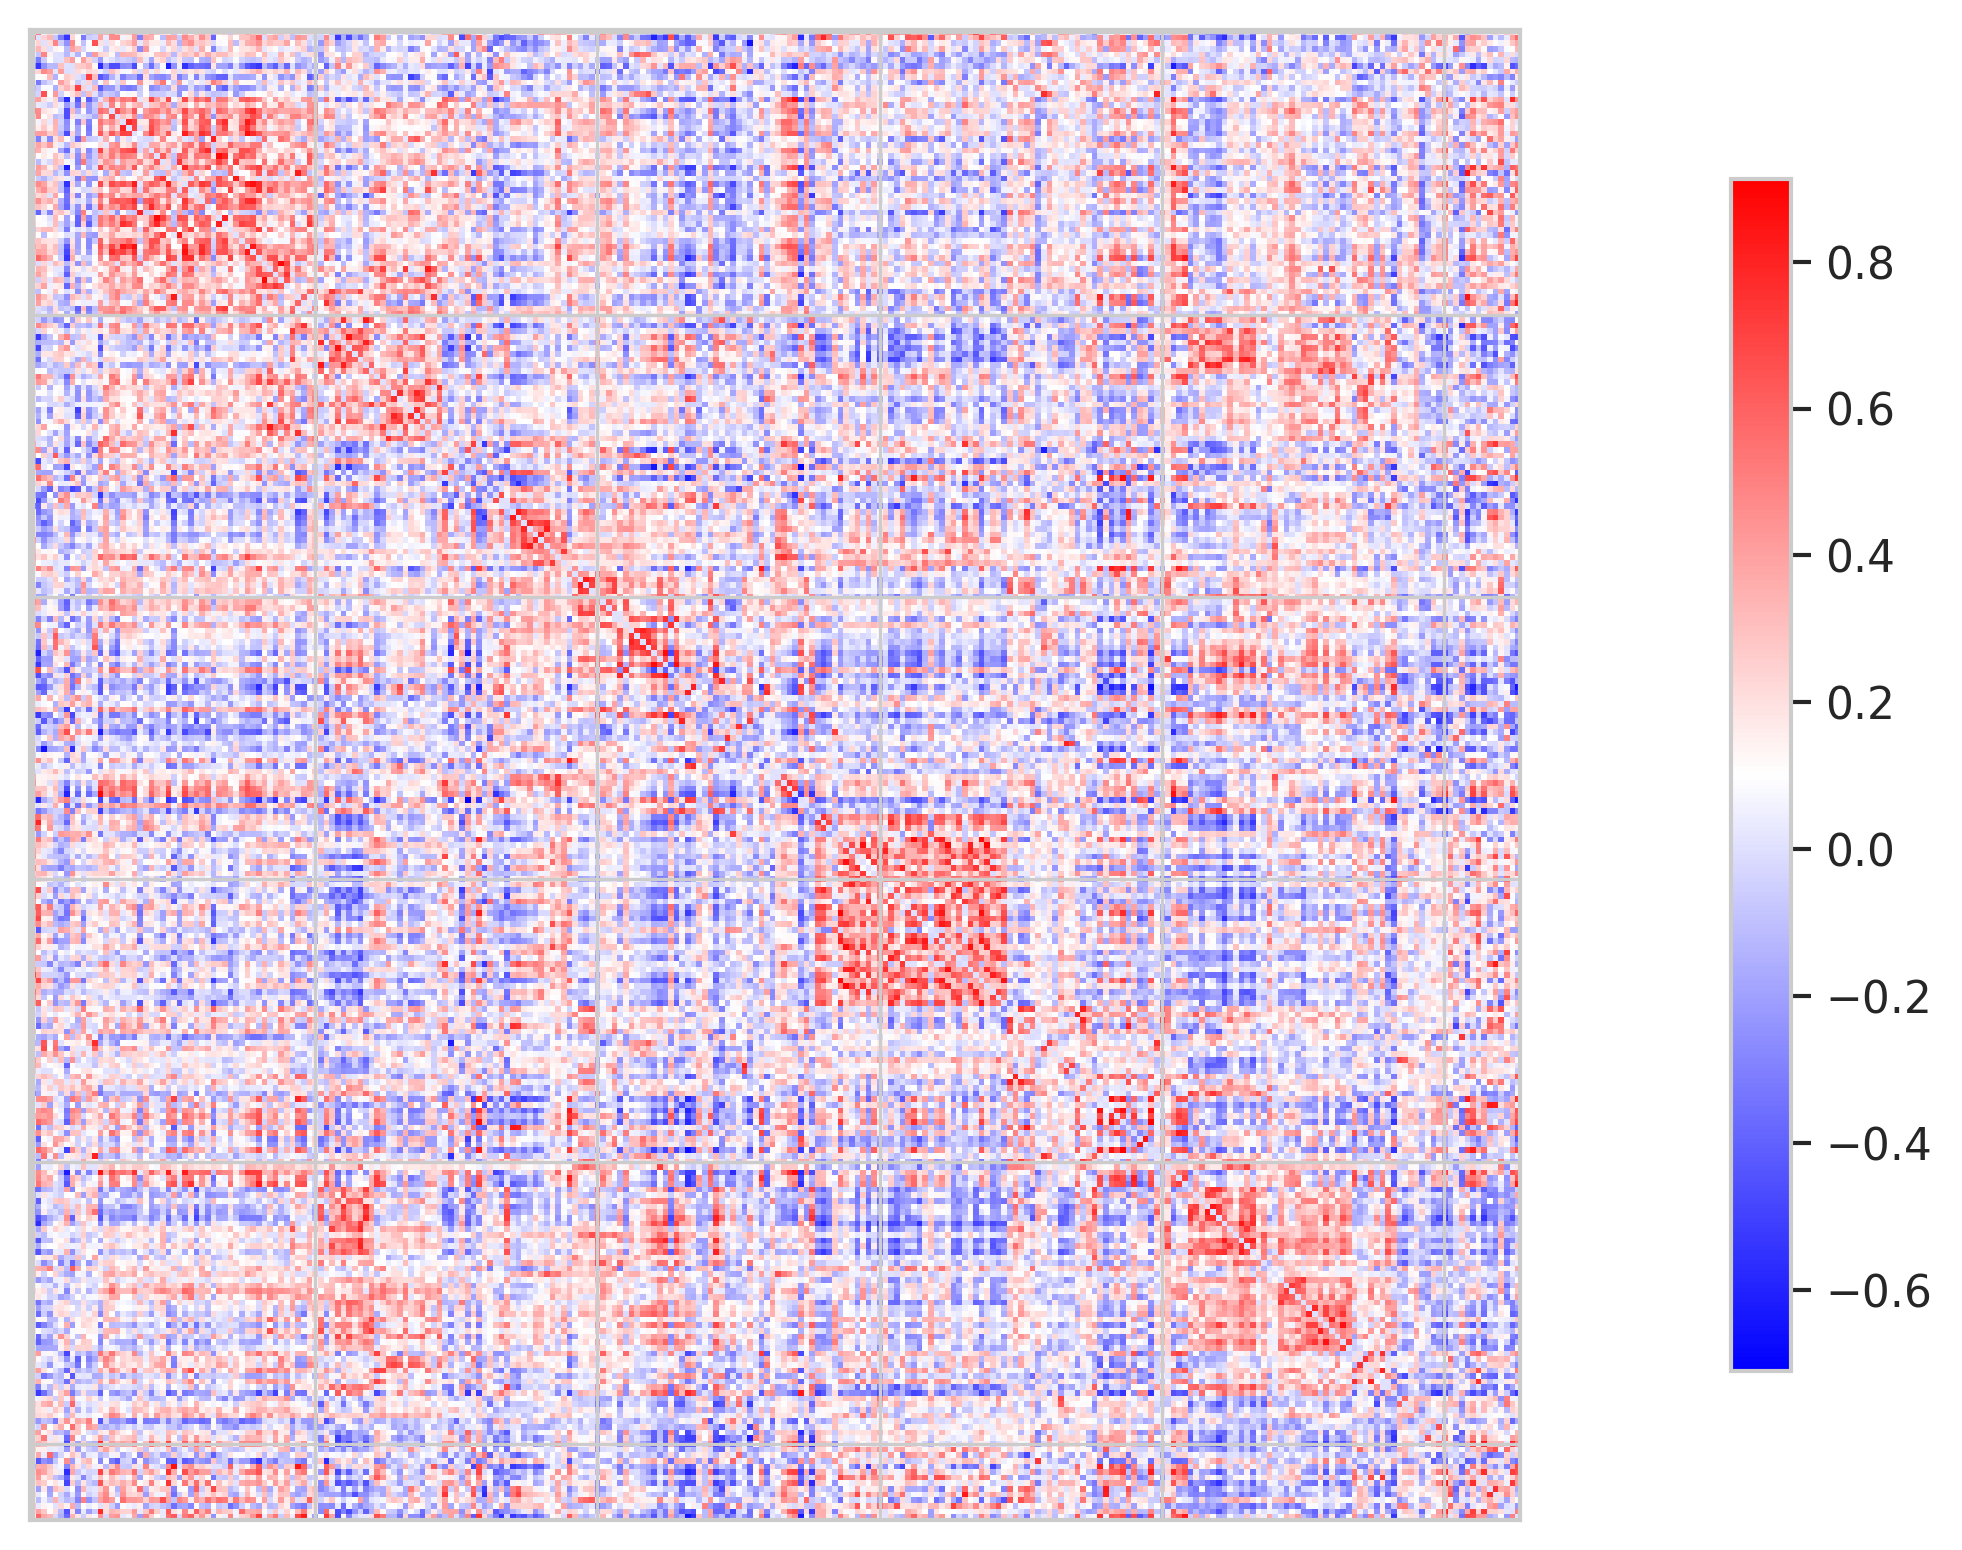

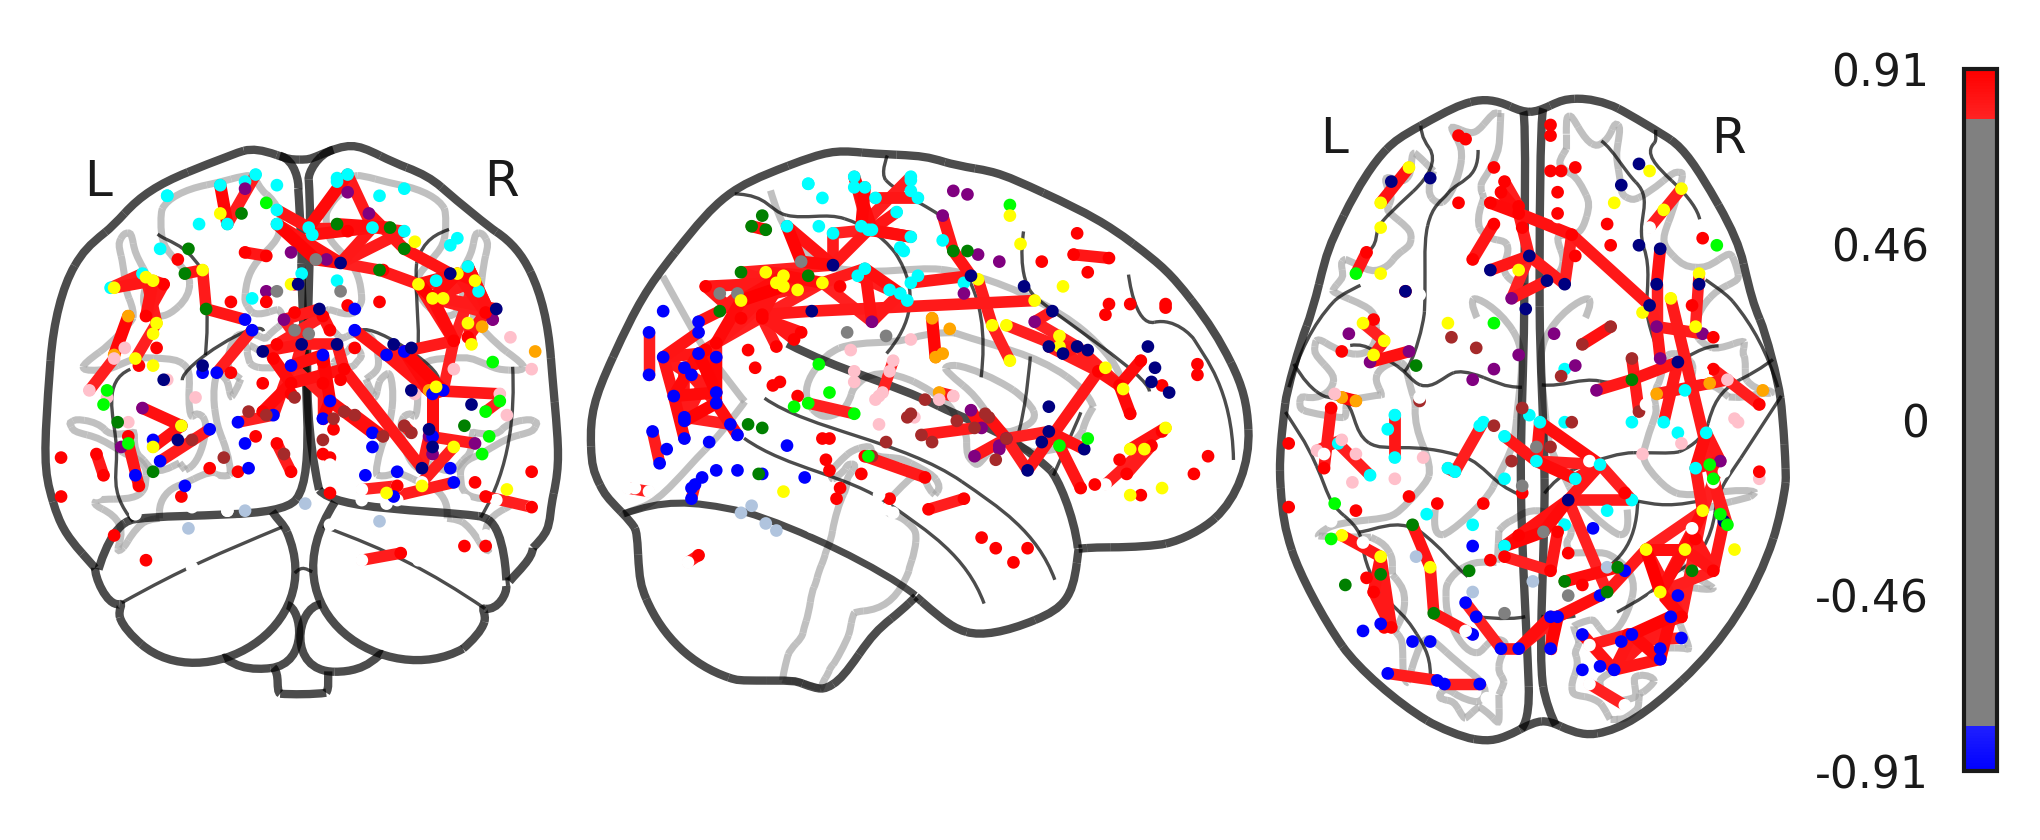

In [18]:
from common.plotting import plot_connections

plot_connections(X[cluster_indices[-1]])
plot_connections(X[cluster_indices[0]][0])

print(cluster_indices[-1], cluster_indices[0])

In [30]:
from common.wisc import WISC_LEVEL

# data = []

for target in WISC_LEVEL[5]:
    y = Y[target]
    y_clusters = [y[indices] for indices in cluster_indices]
    
    print(target)
    for cluster, y_cluster in enumerate(y_clusters):
        print(cluster, '[%s]' % ', '.join(map(str, y_cluster)))
#         print(f"Cluster {cluster} {target}: {np.mean(y_cluster):.2f} ({np.std(y_cluster):.2f})")
    print("---")

#     data += [(1, target, value) for value in y_cluster_one]
#     data += [(2, target, value) for value in y_cluster_two]

# data = pd.DataFrame(data, columns=['cluster', 'target', 'value'])
# display(data)
# g = sns.FacetGrid(data, col="cluster", row="target")
# g.map_dataframe(sns.histplot, x='value', binwidth=5, binrange=(50, 150))

WISC_FSIQ
0 [116, 76, 111, 115, 97, 121, 70, 78, 118, 76, 93, 123, 110, 105, 94, 85, 121, 76, 94, 115, 78, 75, 115, 113, 115, 73, 107, 97, 81, 88, 87, 97, 132, 91, 81, 122, 79, 135, 86, 110, 80, 104, 76, 112, 106, 138, 76, 126, 127, 133, 128, 98, 100, 95, 78, 85, 80, 102, 96, 115, 104, 82, 92, 108, 133, 73, 105, 119, 133, 100, 77, 118, 106, 99, 103, 131, 85, 107, 103, 104, 74, 95, 127, 99, 110, 147, 109, 73, 87, 105, 94, 92, 88, 111, 82, 97, 102, 87, 121, 72, 129, 115, 100, 129, 89, 96, 91, 106, 124, 94, 82, 107, 79, 76, 86, 85, 77, 113, 95, 94, 93, 87]
1 [84, 129, 72, 88, 92, 101, 91, 116, 87, 102, 73, 75, 79, 112, 84, 84, 110, 82, 88, 93, 119, 84, 109, 97, 88, 113, 96, 83, 99, 111, 83, 75, 82, 86, 103, 89, 100, 83, 89, 123, 119]
2 [126, 95, 83, 76, 118, 121, 94, 98, 126, 95, 87, 111, 97, 80, 113, 124, 120, 74, 91, 94, 103, 117, 109, 129, 92, 113, 89, 123, 103, 99, 106, 94, 97, 99, 103, 104, 116, 119, 135, 97, 94, 74, 86, 103, 111, 93, 91, 82, 73, 110, 97, 86, 116, 74, 91, 129, 107, 7